# Slice large area in smaller bounding boxes and request a snapshot each

This script is partially based on: https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html

What this script does:
- Logs in to Sentinel Hub using the API credentials that can be found on your Sentinal account
- Load a json polygon from external source
- Use matplot lib to verify the correctness of the area
- Use SH utilities to split the area on several smaller bounding boxes
- Articulate a request for a single image for each of the smaller areas

Aditionally:
- Defines a time range
- Articulate multiple request for an area and download the images

### Import and configure Sentinel Hub API with credentials

In [1]:
# import config for Sentinel Hub API
from sentinelhub import SHConfig
# import personal config settings – keep them secret!
import sentinelconfig

config = SHConfig()
config.instance_id = sentinelconfig.instance
config.sh_client_id = sentinelconfig.client_ID
config.sh_client_secret = sentinelconfig.client_secret

# save current config settings
config.save()

# prompt warning if no credentials
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


### Import utilities

In [2]:
import os
import datetime

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    read_data,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


# The following are not packages, but .py files in the same folder as this notebook.
# They contain functions to execute analysis tasks
from utils import show_area, show_splitter
from eval_img import evalscript_true_color

from shapely.geometry import MultiLineString, MultiPolygon, Polygon, shape
import numpy as np
import itertools
%matplotlib inline


### Import json file

The file has been generated in Google Earth. I will show you how to do it. You can also follow from step 6 on of this tutorial: https://www.mindat.org/a/geojson_from_google_earth

In [3]:
INPUT_FILE = "./aoi_atacama.json"

geo_json = read_data(INPUT_FILE)
atacama_area = shape(geo_json["features"][0]["geometry"])

type(atacama_area)

shapely.geometry.polygon.Polygon

### Plot and verify AOI

This function can be found in utils.py.
It plots the shapely geomtry to a map: useful to verify the correctness of the area you are using.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-70.20344230307033 -21.14590468414001


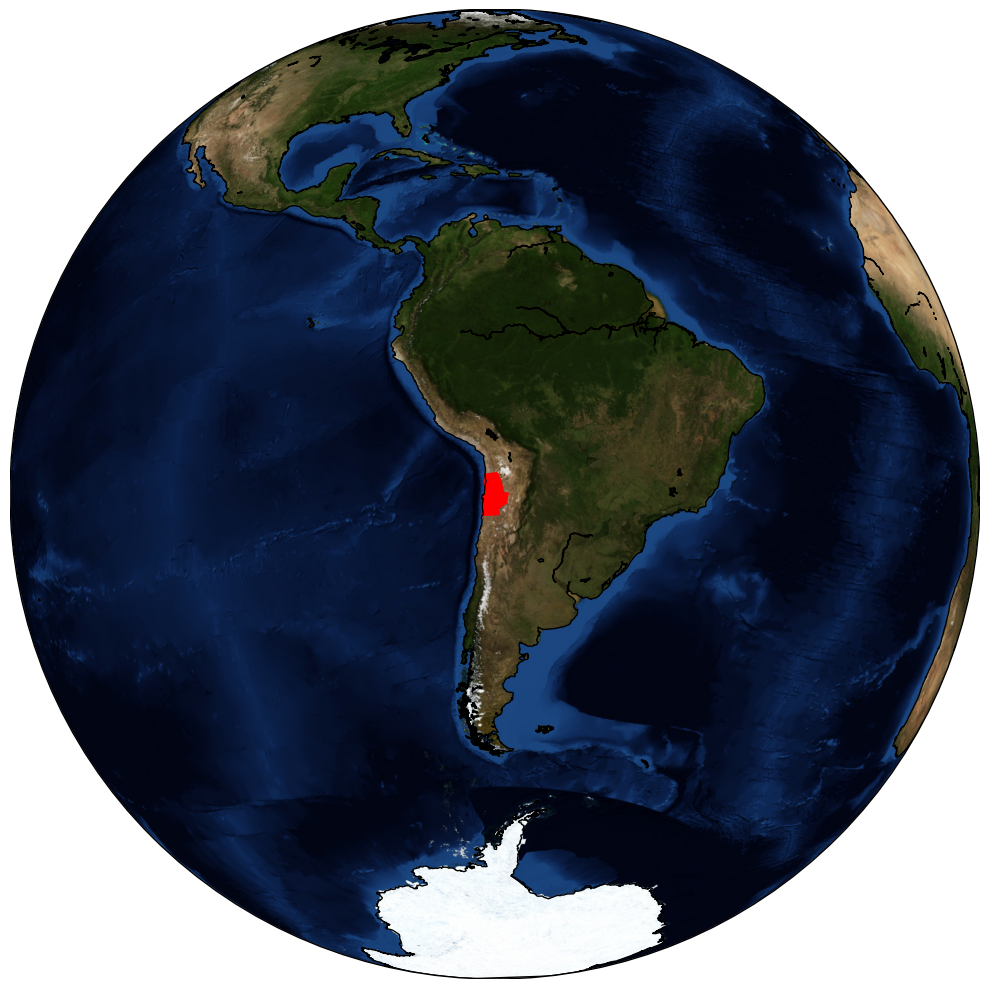

In [4]:
show_area(atacama_area)

### Create a splitter and verify its size

`BBoxSplitter` is part of the SentinelHub API package. It takes a large geo-referenced geometry (Polygon or MultiPolygon – hence non continuous features) and splits it into smaller bounding boxes based on a predefined grid. There are several ways of splitting a geometry, for example you can use the Open Street Map grid: https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html#Splitting-in-OSM-grid

We will use the most basic functionality offered by SH. Other info can be found here: https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.areas.html#sentinelhub.areas.BBoxSplitter

In [5]:
bbox_splitter = BBoxSplitter(
    # The splitter parameters are: the polygon, the CRS, and a tuple of columns and rows to split the polygon
    [atacama_area], CRS.WGS84, (5, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(
    bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-70.622131635392, -25.4766076549912), (-69.9434998799288, -24.218380549740303)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



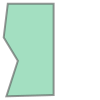

In [6]:
# We can verify the first element of our list

geometry_list = bbox_splitter.get_geometry_list()
geometry_list[0]

### Verify how many areas have been created by the splitter

Again, we use a function available in the `utils.py` file. This function allows you to plot the different rows and columns that have been created by the splitter

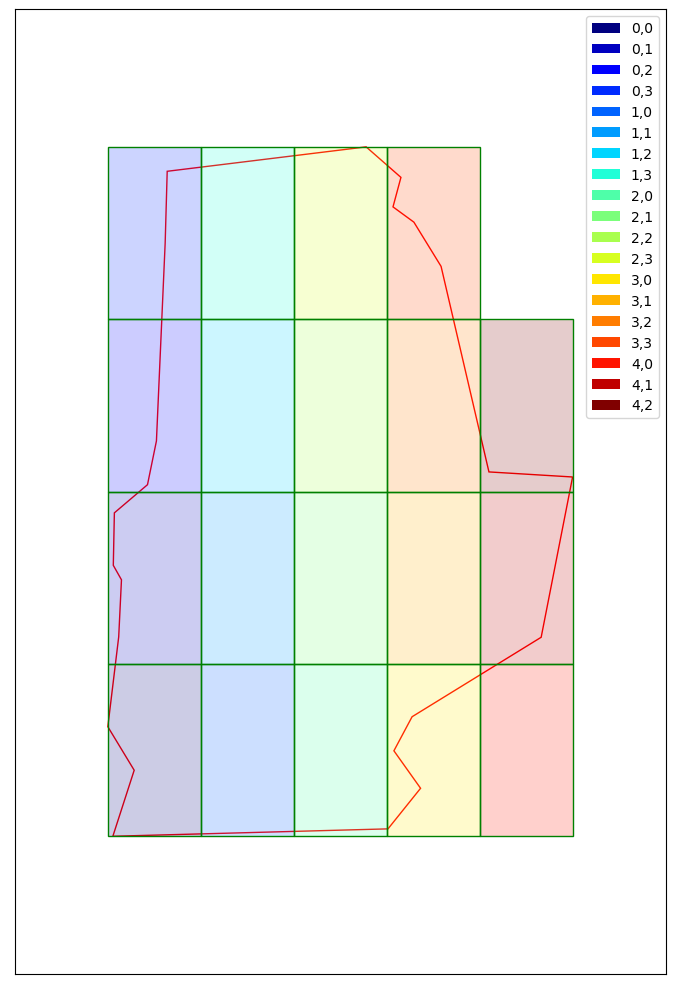

In [7]:
show_splitter(bbox_splitter, show_legend=True)

### Reduced and granular BBox Split? Yes please!

Among other parameters, `BBoxSplitter` takes `reduce_bbox_sizes`. This boolean (True/False) lets you determine if you want to crop your AOI boundaries more precisely. In this example we also make the grid more granular (6x6).

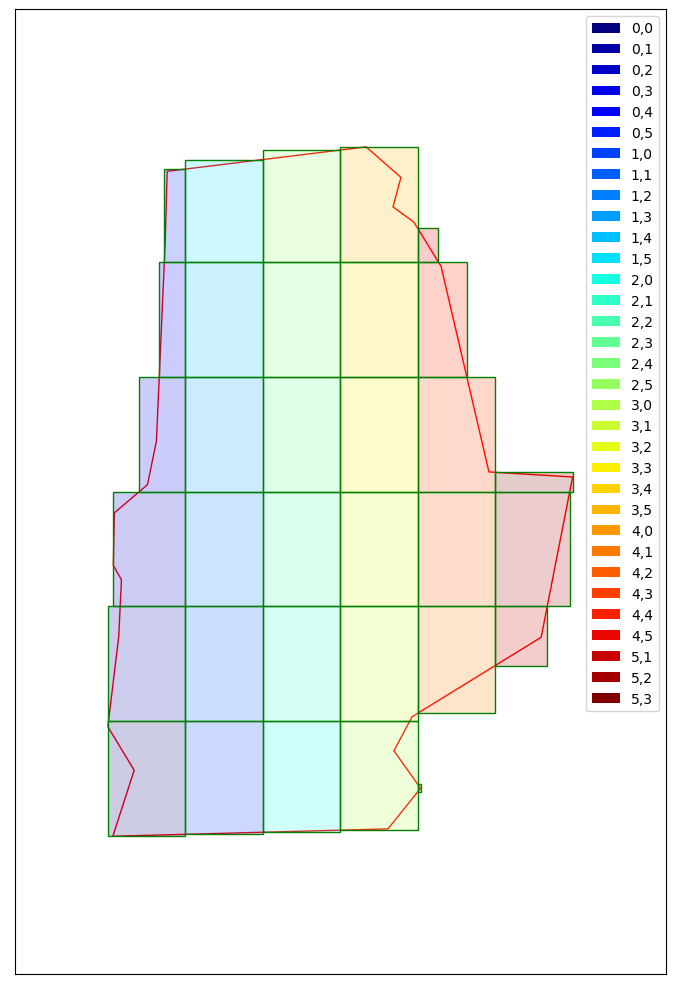

nbbox: BBox(((-70.622131635392, -25.4766076549912), (-70.056605172506, -24.637789584823935)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



In [8]:
bbox_splitter_reduced = BBoxSplitter(
    [atacama_area], CRS.WGS84, (6, 6), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

bbox_red_list = bbox_splitter_reduced.get_bbox_list()
info_red_list = bbox_splitter_reduced.get_info_list()
print(bbox_splitter_reduced)
print("nbbox: {}\ninfo: {}\n".format(
    bbox_red_list[0].__repr__(), info_red_list[0]
))


### Define request and iterate over bounding boxes

This approach combines some functions and methods from previous examples. We define a function for the request including the data folder for export, the data collection, the time interval, the type of export (`MimeType.TIFF`), bbox and area size. These last two variables are parameters of our function, this way we can iterate over our list and pass each bounding box to the API independently.

In [10]:
def get_true_color_request(bbox_area, area_size):
    return SentinelHubRequest(
        data_folder="request_output/area_segmentation",
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=("2020-12-01", "2020-12-31"),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response(
            # There are several types of export, but Tiff allows us to create a georeferenced image!
            "default", MimeType.TIFF)],
        bbox=bbox_area,
        size=area_size,
        config=config,
    )


Here's where the magic happens. Now that we made sure our area is correct and we splitted it in several smaller chunks, we can iterate over the list of bbox coordinates and request a scene for each one of it.

In [ ]:

# Iterate over the splitter list of bboxes
for list_el in bbox_splitter_reduced.get_bbox_list():
    print(list_el)

    # WGS84 coords for Area Of Interest (AOI)
    # Instead of giving only one area of interest, we provide the current bounding box
    area_wgs84 = list_el

    # Same as before, define resolution, bbox, and size
    resolution = 60
    atacama_bbox = BBox(bbox=area_wgs84, crs=CRS.WGS84)
    atacama_size = bbox_to_dimensions(atacama_bbox, resolution=resolution)

    print(f"Image shape at {resolution} m resolution: {atacama_size} pixels")
    # Create request and download list, then pass configuration data and download img
    request = get_true_color_request(atacama_bbox, atacama_size)
    download_list = request.download_list[0]
    data = SentinelHubDownloadClient(config=config).download(
        download_list, show_progress=True)
    
    # Saves image at folder
    for folder, _, filenames in os.walk(get_true_color_request(atacama_bbox, atacama_size).data_folder):
        for filename in filenames:
            print(f"Image with resolution: {atacama_size} pixels, for bbox: {list_el} saved at {folder}")


In [21]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2022, 12, 31)
n_chunks = 33
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Yearly time windows:\n")
for slot in slots:
    print(slot)


Monthly time windows:

('1990-01-01', '1991-01-01')
('1991-01-01', '1992-01-01')
('1992-01-01', '1992-12-31')
('1992-12-31', '1993-12-31')
('1993-12-31', '1995-01-01')
('1995-01-01', '1996-01-01')
('1996-01-01', '1996-12-31')
('1996-12-31', '1997-12-31')
('1997-12-31', '1998-12-31')
('1998-12-31', '2000-01-01')
('2000-01-01', '2000-12-31')
('2000-12-31', '2001-12-31')
('2001-12-31', '2002-12-31')
('2002-12-31', '2003-12-31')
('2003-12-31', '2004-12-31')
('2004-12-31', '2005-12-31')
('2005-12-31', '2006-12-31')
('2006-12-31', '2007-12-31')
('2007-12-31', '2008-12-31')
('2008-12-31', '2009-12-31')
('2009-12-31', '2010-12-31')
('2010-12-31', '2011-12-31')
('2011-12-31', '2012-12-30')
('2012-12-30', '2013-12-31')
('2013-12-31', '2014-12-31')
('2014-12-31', '2015-12-31')
('2015-12-31', '2016-12-30')
('2016-12-30', '2017-12-30')
('2017-12-30', '2018-12-31')
('2018-12-31', '2019-12-31')
('2019-12-31', '2020-12-30')
('2020-12-30', '2021-12-30')


In [27]:
def get_true_color_request(year, time_interval, bbox_area, area_size):
    data_collection = DataCollection.LANDSAT_TM_L2 if year <= 2012 else DataCollection.SENTINEL2_L2A
    return SentinelHubRequest(
        data_folder=f"request_output/area_segmentation/{year}",
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response(
            # There are several types of export, but Tiff allows us to create a georeferenced image!
            "default", MimeType.TIFF)],
        bbox=bbox_area,
        size=area_size,
        config=config,
    )

In [28]:
year = 1990
for time_interval in slots:
# Iterate over the splitter list of bboxes
    for list_el in bbox_splitter_reduced.get_bbox_list():
        print(list_el)

        # WGS84 coords for Area Of Interest (AOI)
        # Instead of giving only one area of interest, we provide the current bounding box
        area_wgs84 = list_el

        # Same as before, define resolution, bbox, and size
        resolution = 60
        atacama_bbox = BBox(bbox=area_wgs84, crs=CRS.WGS84)
        atacama_size = bbox_to_dimensions(atacama_bbox, resolution=resolution)

        print(f"Image shape at {resolution} m resolution: {atacama_size} pixels")
        # Create request and download list, then pass configuration data and download img
        request = get_true_color_request(year, time_interval, atacama_bbox, atacama_size)
        download_list = request.download_list[0]
        data = SentinelHubDownloadClient(config=config).download(
            download_list, show_progress=True)

        # Saves image at folder
        for folder, _, filenames in os.walk(get_true_color_request(year, time_interval, atacama_bbox, atacama_size).data_folder):
            for filename in filenames:
                print(f"image saved at {folder}")
                # print(
                # f"Image with resolution: {atacama_size} pixels, for bbox: {list_el} saved at {folder}")
    
    year += 1


-70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935
Image shape at 60 m resolution: (935, 1558) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1990
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/4cbf3cdda6e54619c5c339244b50d204
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/ea48c288e341f60be84b7dea0c9b2f46
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/7458cd52192796f6c2d5d4fad71e7eb9
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/8abe4a736ee365dd77d0ce1a7af4d3cd
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/862f141a4ecebb875fb6818b0dca1bd5
image saved at request_output/area_segmentation/1990/595333a148fd6bcf840535dc718cefa6
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/8559a5d2f61269e558324ceb40f9d59b
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/b73f75113e09cdba12c4c1f041be428d
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/501f26ac6012765a2853483a11512342
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/a25257d008e31d5d86e5db757425c2bd
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/79758e51c8b91663c9bc381528481f95
image saved at request_output/area_segmentation/1991/420515c42f6160c89f433bdb72d611e8
image saved at request_output/area_segmentation/1991/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
image saved at request_output/area_segmentation/1992/d020edbcfe77d60766c99c9a249ac190
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/882c955f69abb9ad7782330a11e78db0
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1992
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/c047ecb6eaa5cbb2bae8ab705c1e80cb
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/ae161ad439d8b77ca723594a05b5bad5
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/6a39c3ac5a8c8e08da12ac9b488ccfbb
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/fb9c20db6edfe3fef4e7be1aef155908
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/6375679ea67d9508569e1fb8263f0a95
image saved at request_output/area_segmentation/1992/1ebc5339318c0b55c507fde32b6b3b03
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/8dddf4ed347b7f78610d80daf2ab62de
image saved at request_output/area_segmentation/1993/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/f77ff9fed4494dc08b37ef836d276799
image saved at request_output/area_segmentation/1993/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/53136ce948622c27777e1de700e1f618
image saved at request_output/area_segmentation/1993/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/089c425956a8ae42b8012b31ce188db8
image saved at request_output/area_segmentation/1993/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/c31e212c1647da293d2aebcc90727b4e
image saved at request_output/area_segmentation/1993/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/aec39b5ae249c476df5835948d7274c1
image saved at request_output/area_segmentation/1993/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/1923414a83efb14b6153fcc1a60dbe27
image saved at request_output/area_segmentation/1993/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/08bcfd394e37dc7a5cf629ad70b68d6c
image saved at request_output/area_segmentation/1993/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/9d68c924e09a5e8df408075af84e07f3
image saved at request_output/area_segmentation/1993/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/8dcb8a77dee8f369c74f10d5ceaafea2
image saved at request_output/area_segmentation/1993/8dcb8a77dee8f369c74f10d5ceaafea2
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/8e4341cdbda5c3f03e56e8680cee1057
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/b07038403fb133ce740d6177577f5973
image saved at request_output/area_segmentation/1993/8dcb8a77dee8f369c74f10d5ceaafea2
image saved at request_output/area_segmentation/1993/8dcb8a77dee8f369c74f10d5ceaafea2
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/6bf4241a6955025c79454de6ffa63658
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/09be85e9bccea3b90acdb33cecd8b75a
image saved at request_output/area_segmentation/1993/e2037796651f6711c3261c03dfb0036f
image saved at request_output/area_segmentation/1993/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/34c00483bb193d57382d345696429c39
image saved at request_output/area_segmentation/1994/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/34c00483bb193d57382d345696429c39
image saved at request_output/area_segmentation/1994/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/873c539b48d259fde6fe9313c8f68eba
image saved at request_output/area_segmentation/1994/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/9ce21bbfb689f2a8de6b2bfea4d7d17d
image saved at request_output/area_segmentation/1994/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/0f4e51f8979405c04a3dea10ccd040e3
image saved at request_output/area_segmentation/1994/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7a87e4744287c3794f1dbe518a7773e9
image saved at request_output/area_segmentation/1994/7a87e4744287c3794f1dbe518a7773e9
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7a87e4744287c3794f1dbe518a7773e9
image saved at request_output/area_segmentation/1994/7a87e4744287c3794f1dbe518a7773e9
image saved at request_output/area_segmentation/1994/3068fc72e950b3d6ed5b7587ed856779
image saved at request_output/area_segmentation/1994/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7a87e4744287c3794f1dbe518a7773e9
image saved at request_output/area_segmentation/1994/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/7258fa73ef181f921049cfe3ee7dc5dc
image saved at request_output/area_segmentation/1994/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/fe98caf5f96f06c2a64ab09420bbe5be
image saved at request_output/area_segmentation/1994/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/e706ee6a2421a215adb736b3ed0875e8
image saved at request_output/area_segmentation/1994/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/fa1bbcf5439962279e51e516bb5970cc
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/3d492d2ad9b9ac232c15b0beab2462a2
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/11d49f5ea29073d5ca1cfc1b888647ae
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/1d870e6da7c17b1251e58233f6c57a95
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/b3af4f6bf49b1012e3e09b041fa7e426
image saved at request_output/area_segmentation/1994/c716afe73ae2bc2404e87a8f5356f5bb
image saved at request_output/area_segmentation/1994/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
image saved at request_output/area_segmentation/1995/0ea2e90b5dddb4781151511b716cc897
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
image saved at request_output/area_segmentation/1995/4d2643516cd0c80dd13b9f086fb99e3c
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
image saved at request_output/area_segmentation/1995/e0315dac69f0d9f54e6833b0628f40ab
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
image saved at request_output/area_segmentation/1995/22e3bdb9ce733f5cb02858d215ed8577
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
image saved at request_output/area_segmentation/1995/26105d2bd2dea50d2f22b6b6380d1dc1
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/6ccefb774b68d97265cd51e829a4325b
image saved at request_output/area_segmentation/1995/6ccefb774b68d97265cd51e829a4325b
image saved at request_output/area_segmentation/1995/6fa6e8e5ad65913ea4df7a0c5fcd1c01
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/6ccefb774b68d97265cd51e829a4325b
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/6ccefb774b68d97265cd51e829a4325b
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
image saved at request_output/area_segmentation/1995/6ccefb774b68d97265cd51e829a4325b
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
image saved at request_output/area_segmentation/1995/9ebfd5a672f5e0cb2aca5d13b4abd6f4
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1995
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/481ba42d0d94354a58e71647f5eef5fe
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/8d5314edc3ce467c497527dfe691e9e6
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/4c11ead7f82a943280d9fc0378d19179
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/72fd328d3fcc47b82e4cadbb84fec973
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/196d436a435aed12f915d13661fcb517
image saved at request_output/area_segmentation/1995/b7bb692663eee6c108c8a323de18ff68
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/2b2ce99c5f926734199f74f943b9eae0
image saved at request_output/area_segmentation/1996/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/7e723907a573466aff29668093b2fb5f
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/7e723907a573466aff29668093b2fb5f
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/0b29151c8e835a15e3b51d57928b2959
image saved at request_output/area_segmentation/1996/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/9b050c6db43e82f001f7ce7c1933c987
image saved at request_output/area_segmentation/1996/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/08bf9db4b194d65f4ad5e54616f2ae61
image saved at request_output/area_segmentation/1996/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/66e65400bc16afa88cae9c2c507cb20d
image saved at request_output/area_segmentation/1996/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/6a982fcf6367b6705186d8ed5f63e971
image saved at request_output/area_segmentation/1996/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/126559bbc86e7239e590bd2e7f43ab37
image saved at request_output/area_segmentation/1996/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/7ec8322822a15c4580870a10de4a20a1
image saved at request_output/area_segmentation/1996/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/eee01e21ece6add9bf13123a803c7348
image saved at request_output/area_segmentation/1996/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/37a07be4950931350e7d1ce26ae990eb
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/29bae2048a074d273a1c274b145abaa6
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/1983fa076c5812169803be78958eefbc
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/19e2636fa9fb8cbdbf7c0d1404b17f9a
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/4470911e16cc6f13f31da9e0aa5a2db2
image saved at request_output/area_segmentation/1996/b8043b753aa30d31eaf15f6da4009475
image saved at request_output/area_segmentation/1996/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/1f69e309ce9c351dec7ee90d9ec5cdff
image saved at request_output/area_segmentation/1997/1f69e309ce9c351dec7ee90d9ec5cdff
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/1f69e309ce9c351dec7ee90d9ec5cdff
image saved at request_output/area_segmentation/1997/1f69e309ce9c351dec7ee90d9ec5cdff
image saved at request_output/area_segmentation/1997/bb90bd33ea9822a6a9247b289e23a4e1
image saved at request_output/area_segmentation/1997/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/1f69e309ce9c351dec7ee90d9ec5cdff
image saved at request_output/area_segmentation/1997/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/9383b8bb91112598e29e7fe95e97a2ce
image saved at request_output/area_segmentation/1997/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5b00e7ff1e962a3ab6c2babcc2c2fbef
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/5ddedda291379c46afbd867254cd1d5d
image saved at request_output/area_segmentation/1997/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/7a95dcbcdafedb6a388447db295e16e2
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/8e81cd2d52a2685cccce486641b71ceb
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/f203a5af662cf83a6548cd77a0559c03
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/22b13ee06ceeb2777a6410e9e665829e
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/d3a298ed2f1161fd123bdbdfa3541fdb
image saved at request_output/area_segmentation/1997/c93b64aef4532ed7e003525d84456987
image saved at request_output/area_segmentation/1997/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/4de7c8d4e107bcbca7eb198ba26a3dc4
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/860e6953aafda8f6c800a2ca69bc438f
image saved at request_output/area_segmentation/1998/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/75fdb08a219811cde7514b3fdadcdd96
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/5cbc9289bf0bcc8a77a0fc0e200f4717
image saved at request_output/area_segmentation/1998/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/02315a78dfb79764d8a7eeb8c2442e0a
image saved at request_output/area_segmentation/1998/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/2c90fe3a5fb676984c5f08305935057e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/7e1a69090cacf8c31ab0221550119410
image saved at request_output/area_segmentation/1998/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/64e083944ff04761f6f39f68ea648226
image saved at request_output/area_segmentation/1998/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/294d5410da6c1710ade0566114d8485e
image saved at request_output/area_segmentation/1998/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/2df61abf9dc99e124e322808c93f562b
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/9b447dd4dc149e58cec3e24ff81e82a2
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/8025b25c648a963d1e52804d22bca106
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/ea77c8edf4a2ce29ac1a3a8d6ed3b832
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/72cb2554529597d991a943bede3128d3
image saved at request_output/area_segmentation/1998/4626679720645dfc6e06e93338c4cb51
image saved at request_output/area_segmentation/1998/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/149d79aa46eb25370804f0058b6098de
image saved at request_output/area_segmentation/1999/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/f1ad0902ef42c453fbba2c4c2216cff7
image saved at request_output/area_segmentation/1999/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/51af1ad91933429a52d88bfc0a129122
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/d1f366c2f23c3931d77a6c92c1228dc5
image saved at request_output/area_segmentation/1999/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/56f3740824ea7c735bb0ebe3e351319f
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/76781a553071cad69fecde62b79fbf5a
image saved at request_output/area_segmentation/1999/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/b8dece7ee3850481dc6c28b5b99f96c0
image saved at request_output/area_segmentation/1999/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/53ae240f7e0597b0e94a11f8a0821501
image saved at request_output/area_segmentation/1999/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/c98926e3cb22e11549c59ecaf84c64a2
image saved at request_output/area_segmentation/1999/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/927d0b4f418cefb6824c1b05acc0a0aa
image saved at request_output/area_segmentation/1999/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/ffa5e198da02442845dfda5a28e5eac9
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/3dc7ef64403e1871c9abb4b8ead2da71
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/f041fbdcc9971beb0096e3f847446e15
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/a4993deec2daeae995d146a83ffb2ca7
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/8a600c9b5b2a8d5922e50ad7a28a7282
image saved at request_output/area_segmentation/1999/0a0cdc9993ee9eb7849f55f9e5ef3824
image saved at request_output/area_segmentation/1999/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/b917c0a5092599965c22aa7da326aa81
image saved at request_output/area_segmentation/2000/b917c0a5092599965c22aa7da326aa81
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/fd2c5af3d9fdc0f5540ec929b050e0cd
image saved at request_output/area_segmentation/2000/fd2c5af3d9fdc0f5540ec929b050e0cd
image saved at request_output/area_segmentation/2000/b917c0a5092599965c22aa7da326aa81
image saved at request_output/area_segmentation/2000/b917c0a5092599965c22aa7da326aa81
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/fd2c5af3d9fdc0f5540ec929b050e0cd
image saved at request_output/area_segmentation/2000/fd2c5af3d9fdc0f5540ec929b050e0cd
image saved at request_output/area_segmentation/2000/b917c0a5092599965c22aa7da326aa81
image saved at request_output/area_segmentation/2000/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/fd2c5af3d9fdc0f5540ec929b050e0cd
image saved at request_output/area_segmentation/2000/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/f349dc16db07dbad432973a2c1526957
image saved at request_output/area_segmentation/2000/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/3b1e36309a5dab3004b36dfef15eab0a
image saved at request_output/area_segmentation/2000/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/c0a59017a5ace7e451977d2ae8616c91
image saved at request_output/area_segmentation/2000/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/537fdccb9872e871335b8cd39a649124
image saved at request_output/area_segmentation/2000/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/2ef7193d79a8e27faf63450cb94ecff1
image saved at request_output/area_segmentation/2000/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/4156dc40160d49d6946af720e394e2de
image saved at request_output/area_segmentation/2000/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/4156dc40160d49d6946af720e394e2de
image saved at request_output/area_segmentation/2000/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/33f2e94b94aafd0d77580e5c3ef01e5d
image saved at request_output/area_segmentation/2000/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/01c7f6f4c38e2bd07290bddeaa1c7ee8
image saved at request_output/area_segmentation/2000/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/863ee7bfb4775d3995236263b4c2f84a
image saved at request_output/area_segmentation/2000/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/6a59d5df1efbe828c5987faea960d318
image saved at request_output/area_segmentation/2000/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1228c538b83b903e04b157716cee7fda
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/23718a9402ecbda67923c1384d43fda6
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/4d8505ee992506fcb847c13d07a64e89
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/405bab1b97942183ae042c16e5b94786
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/0c0fae80b1f9ba3db657c89c9ed1d194
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/4baa28a9a2802bcf452c3985f7eaa984
image saved at request_output/area_segmentation/2000/11038e180d75afe509d585aa4d9c94f5
image saved at request_output/area_segmentation/2000/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/096267ddc33b44d7560e9823e64cf31f
image saved at request_output/area_segmentation/2001/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/cb1e5c7cbf00535087a3ea734c0d2994
image saved at request_output/area_segmentation/2001/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/c47ed745fa509d45849b1a9cbddc133f
image saved at request_output/area_segmentation/2001/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/e86cb8339780b52432e57f4a62912616
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/704dd5d866eb36192331415664a6fa53
image saved at request_output/area_segmentation/2001/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/f3e4e50abd94d346d45c650455700406
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/eb95852028a0d6cbe71cf9291d94e526
image saved at request_output/area_segmentation/2001/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/914f8fac2ae85cac4332bd98316f136b
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/24d6685288aac1a2b0ef6b1f16eaa508
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/5d9c8782fee56a2a060d645aaebb3d21
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/1b75ba9b7293639bd3abbaee72dd6569
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/7ab71d2aa891fcf3ef2b1141cfca0764
image saved at request_output/area_segmentation/2001/f63b734b67f39d2dce6a8e5de0812060
image saved at request_output/area_segmentation/2001/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/a66f30ec3481aea460c2ec77e01799ef
image saved at request_output/area_segmentation/2002/a66f30ec3481aea460c2ec77e01799ef
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/a66f30ec3481aea460c2ec77e01799ef
image saved at request_output/area_segmentation/2002/a66f30ec3481aea460c2ec77e01799ef
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/a66f30ec3481aea460c2ec77e01799ef
image saved at request_output/area_segmentation/2002/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/3228cb93afad0ee4cfc34ebcfa717d8e
image saved at request_output/area_segmentation/2002/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/546cde4919f6e48ff4d48247c0e13500
image saved at request_output/area_segmentation/2002/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/4cf2654c90ef558eb7c0838685a5f45a
image saved at request_output/area_segmentation/2002/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/bfd9c83fc669ddf41508fd46622bbf1e
image saved at request_output/area_segmentation/2002/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/6df5a000e287abb456528dfdf71bd17a
image saved at request_output/area_segmentation/2002/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/f942a72d0a78180bb5bfca055eaefe8b
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/0ddcac29638be408dcfa4939691bc4c2
image saved at request_output/area_segmentation/2002/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/2d701bf2a34e9d71ed6a7cdfe5bc2adc
image saved at request_output/area_segmentation/2002/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3f9ffbd1ba7713b3099bed1c351ea0ba
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/3c56ceb8c5b3fb5ff3600379a5736aa6
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/b54f6b73d826f9ea48efa7364a06e1ae
image saved at request_output/area_segmentation/2002/c7b79a339333c448fd9e2e52b194c10b
image saved at request_output/area_segmentation/2002/c7b79a339333c448fd9e2e52b194c10b
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/b1c9a399cb8d6a7bebdde15d65dcdf16
image saved at request_output/area_segmentation/2002/fb93242dc5b52aff82c76b702f73ae90
image saved at request_output/area_segmentation/2002/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
image saved at request_output/area_segmentation/2003/7e461fb56b98c06a98f6686fd66d09d5
image saved at request_output/area_segmentation/2003/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/bcb425f79561a113857c96bb1bfc4703
image saved at request_output/area_segmentation/2003/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/7aaa45eec658dc2b954c115aca9a9a96
image saved at request_output/area_segmentation/2003/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/f4b344176088449a746f2b4dd4a33eec
image saved at request_output/area_segmentation/2003/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/dc42dea2be00c0d334b1fe886fe76f7e
image saved at request_output/area_segmentation/2003/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/3453d111087c9ed85356c410829e80e1
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/4fcde3ba817a1f35fbdf5f701c29e4c1
image saved at request_output/area_segmentation/2003/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/852dd74b2500e49f14997c7fd6707857
image saved at request_output/area_segmentation/2003/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/340375df69f4a3981b359dc477a235ee
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/4da7208f02d36d8421d9f91ee0c43231
image saved at request_output/area_segmentation/2003/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/3851255b889b15fd85355a63bdaf864a
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/ace1a60889d60f075e00f920db0896bf
image saved at request_output/area_segmentation/2003/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/42e3ee30c2055072a8bf715268ca4767
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/b3ce769c20aa1c4f1a0b04280cfbb7d3
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/dada75b685a8df152ba8b8eac0b0006e
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/acacace13d13c7578f23ab2eeb286b2a
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/99970591544808edecaf57121fcba799
image saved at request_output/area_segmentation/2003/3af1fd6e603967d34a324e04b7777323
image saved at request_output/area_segmentation/2003/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/e6c08a67468ee22acd65304f86d56a07
image saved at request_output/area_segmentation/2004/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6a4f2edd6f5812d52c7d44975ac7fd57
image saved at request_output/area_segmentation/2004/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/32b2db936533a02048e3e3d0b7d7ea16
image saved at request_output/area_segmentation/2004/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/ae278bde50197fbcb02a4a2eeaeb0ae3
image saved at request_output/area_segmentation/2004/ae278bde50197fbcb02a4a2eeaeb0ae3
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/ae278bde50197fbcb02a4a2eeaeb0ae3
image saved at request_output/area_segmentation/2004/ae278bde50197fbcb02a4a2eeaeb0ae3
image saved at request_output/area_segmentation/2004/6d50939c00d9ac9e41b8c676f8c02b7e
image saved at request_output/area_segmentation/2004/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/ae278bde50197fbcb02a4a2eeaeb0ae3
image saved at request_output/area_segmentation/2004/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/980dffe5fe043a6e5b2c5ca331e0f7c9
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/4ee8d9aba29bbd4c92782768f6b4e212
image saved at request_output/area_segmentation/2004/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/38eaa60a3bf172bb36d13a6f41f4e8cd
image saved at request_output/area_segmentation/2004/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/bf2febff8db4ff72428be0a23d350ecd
image saved at request_output/area_segmentation/2004/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/1f833a2d3d1820e45b1b5748f8fbefe1
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/ae695d8f82e070a0554323f1924af3a3
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/f7fbb3da3866732d318ba2c0e1cbdd64
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/41567caff85024e58eb8a9b54e7e39ac
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/b2868840579d1477b27e9b7d242cc0ab
image saved at request_output/area_segmentation/2004/96fcc7839f64e6e98950d7bad6cc7995
image saved at request_output/area_segmentation/2004/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/2d738b1db54b518343092e325d254f97
image saved at request_output/area_segmentation/2005/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/7c6941beaba8eafdb96a412ad31cbcb0
image saved at request_output/area_segmentation/2005/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/6f7f6d6c4c1a97ae71eecb74871d7418
image saved at request_output/area_segmentation/2005/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/25c9d203eef2fd13c7df0d08e6a1d99d
image saved at request_output/area_segmentation/2005/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/0fb3302085bef459d890532226bf7995
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/ae4cb693069c6ab8f83faf23cd3a0832
image saved at request_output/area_segmentation/2005/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/046f59b9ce9197245e8098bd836d3cb1
image saved at request_output/area_segmentation/2005/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/5082136299a5531a2c2b29282d1d8ebc
image saved at request_output/area_segmentation/2005/5082136299a5531a2c2b29282d1d8ebc
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/5082136299a5531a2c2b29282d1d8ebc
image saved at request_output/area_segmentation/2005/5082136299a5531a2c2b29282d1d8ebc
image saved at request_output/area_segmentation/2005/870d86a589a7a7233681638d898e6d60
image saved at request_output/area_segmentation/2005/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/5082136299a5531a2c2b29282d1d8ebc
image saved at request_output/area_segmentation/2005/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/eea4b78b99eedf017d63561ab560c367
image saved at request_output/area_segmentation/2005/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/14546023085b743d31ee1c0d34afa3b7
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/293b1729f4c2814fdf84e08e3f482613
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/a26eb49cefd5faa315b36f61e64eb040
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/3c5710da74adfbc1a101106c99fa1289
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/8d45cc4d29adf105e8f4bbf1d3552785
image saved at request_output/area_segmentation/2005/f930fac91fea4444280fb8f86752d276
image saved at request_output/area_segmentation/2005/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/dc952ce9270a819875ef58fc7a3d3561
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/d6763c947ef20275b838c2a85ec0ea2f
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/3066db368b447535edbdf3ae15838b13
image saved at request_output/area_segmentation/2006/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/7159b90dea1a3efc924f3915c549868d
image saved at request_output/area_segmentation/2006/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/07e3a4fcf5b7739c19a8bf6f2d95734b
image saved at request_output/area_segmentation/2006/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/477675a48d19a79de90b8472957ae724
image saved at request_output/area_segmentation/2006/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/d0ef7845a56916a0d7d19c8ba49708e0
image saved at request_output/area_segmentation/2006/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/b1eba419762c42995a71d91f1f5e9d07
image saved at request_output/area_segmentation/2006/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/13852c6c653d48f20809626328e754d9
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/c451db1fb94095c4bccc6e1cab25d244
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/40ae7a289fbc9a468e43ccd1fb12a9db
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/a94786ee610db4ce8231ed30f81a85be
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/7d66c89b454f48f4355e0e3c89a8e9fc
image saved at request_output/area_segmentation/2006/b1eba419762c42995a71d91f1f5e9d07
image saved at request_output/area_segmentation/2006/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/6d9c440dfe6198977be0d474cd40dd56
image saved at request_output/area_segmentation/2007/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/d2fd19727ff6063b48006472dd2f7b64
image saved at request_output/area_segmentation/2007/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/aab7b8472a6fdf2b6d63590421ea5449
image saved at request_output/area_segmentation/2007/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/e220ff3fcf19e919fade2ed21c79ccad
image saved at request_output/area_segmentation/2007/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/1cd424bef19dc48e9284447ee71a96bc
image saved at request_output/area_segmentation/2007/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/21aee15765bf9fbc602093d623f80536
image saved at request_output/area_segmentation/2007/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/911e692bc31871821e1c5848c5e15127
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/fccf0c4d7c5fb5382bbf0581f81fa6be
image saved at request_output/area_segmentation/2007/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/4c6bfbd5e9697deca18edab355b00a9a
image saved at request_output/area_segmentation/2007/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9b4d818c03936ec2f2b968c2cacddb28
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/93b2bade85ceb0021b8dfe4d81d529a0
image saved at request_output/area_segmentation/2007/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/6c4d47c9629c229ac0535ba18cd673ac
image saved at request_output/area_segmentation/2007/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/04625d49f632a292fbbcc0beea216e57
image saved at request_output/area_segmentation/2007/04625d49f632a292fbbcc0beea216e57
image saved at request_output/area_segmentation/2007/0761d2d423fde3539e927c3e1112a6a7
image saved at request_output/area_segmentation/2007/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/04625d49f632a292fbbcc0beea216e57
image saved at request_output/area_segmentation/2007/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/04625d49f632a292fbbcc0beea216e57
image saved at request_output/area_segmentation/2007/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/9ee2438ac96fda3cf9d82da5b86b86e4
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/221882d558853024c1c9aaf2ca4ea151
image saved at request_output/area_segmentation/2007/13d861c1433c943da2964d7e4ac6fa10
image saved at request_output/area_segmentation/2007/13d861c1433c943da2964d7e4ac6fa10
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/f42c58fe47b6364dfa762df96037067d
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/a5b0530c560ca39d69b9d56cacec8213
image saved at request_output/area_segmentation/2007/f39062c58c018366c8e60d2fab36e7d3
image saved at request_output/area_segmentation/2007/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/ac0e0c1b18fef722842aa971c5cf39d0
image saved at request_output/area_segmentation/2008/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/5da0ebcdc31aa57a5347369f5dfe808a
image saved at request_output/area_segmentation/2008/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/0046d276e6e6385a8bb633dbfb84932c
image saved at request_output/area_segmentation/2008/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/f0220d68ae37a88336fbfc4dab567944
image saved at request_output/area_segmentation/2008/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/5c40723243f5e90643f2392cc0243672
image saved at request_output/area_segmentation/2008/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/a929878feb1df9229a6078d8dcb4a4d5
image saved at request_output/area_segmentation/2008/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/c3998beb4c14d8216a7590942ae5d492
image saved at request_output/area_segmentation/2008/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/63115eb9dfe9506b331f892a14972781
image saved at request_output/area_segmentation/2008/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/988933d07244fabedf633f82a1d3e296
image saved at request_output/area_segmentation/2008/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/32b67b213537da3f20e9340ec44aec09
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/11fef2cfc7f6da14cec42ada33ed9c16
image saved at request_output/area_segmentation/2008/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/37eb0d42c467a62860725cb3a9336951
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/620f68ca629dcf855d5d916cb2d874b9
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/ee80b6e25a488975309b562988e04529
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/6ce63fb90380d9796029cebd6b55e13d
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/aaba8fd3c5ca4e0f9650168930c0bac8
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/ea2d5195734f7714869dc1219c4adbae
image saved at request_output/area_segmentation/2008/37eb0d42c467a62860725cb3a9336951
image saved at request_output/area_segmentation/2008/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/a2714be8a1ea915e180d35356dfdc466
image saved at request_output/area_segmentation/2009/a2714be8a1ea915e180d35356dfdc466
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/a2714be8a1ea915e180d35356dfdc466
image saved at request_output/area_segmentation/2009/a2714be8a1ea915e180d35356dfdc466
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/a2714be8a1ea915e180d35356dfdc466
image saved at request_output/area_segmentation/2009/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/d96b249fbd82c289cc560cec5c65fd1d
image saved at request_output/area_segmentation/2009/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/be18aa1b77f6649c5bdf6eabd359176e
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/749b21e9813adc57118b7a622da7c1c8
image saved at request_output/area_segmentation/2009/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/b2e0fc5cb98e0ca3c8d437cd3f11f316
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/9f671ab99c1637303dc5c3d03cf78a15
image saved at request_output/area_segmentation/2009/9f671ab99c1637303dc5c3d03cf78a15
image saved at request_output/area_segmentation/2009/2801b3958086d317a6330ec056c7eb78
image saved at request_output/area_segmentation/2009/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/9f671ab99c1637303dc5c3d03cf78a15
image saved at request_output/area_segmentation/2009/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/9f671ab99c1637303dc5c3d03cf78a15
image saved at request_output/area_segmentation/2009/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/420fe474c9ad8fa42997b72077f28b81
image saved at request_output/area_segmentation/2009/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/8af40bfdc54cb5ed4e59232c72c77f4f
image saved at request_output/area_segmentation/2009/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/8af40bfdc54cb5ed4e59232c72c77f4f
image saved at request_output/area_segmentation/2009/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b4e3f62b8d1a5d5f952e42a452d26266
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/1d1ebe4a7123309a47cfd60e4f9ad2ad
image saved at request_output/area_segmentation/2009/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/1d1ebe4a7123309a47cfd60e4f9ad2ad
image saved at request_output/area_segmentation/2009/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/1d1ebe4a7123309a47cfd60e4f9ad2ad
image saved at request_output/area_segmentation/2009/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/b9038e0f2eb4b90b6e0bfb07da5677a4
image saved at request_output/area_segmentation/2009/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/ab4ebb0ed26a87512158009b6681bd03
image saved at request_output/area_segmentation/2009/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/534c1644a62fe9bd978abfbda7a50943
image saved at request_output/area_segmentation/2009/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/93bbc70dd2be3c4a5a220a207a1a8df0
image saved at request_output/area_segmentation/2009/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/64c42c1d35a5aa5a0c4b182d5ffbe49c
image saved at request_output/area_segmentation/2009/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/8021cdd06370a5e762326ce32169ffd6
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/db10a3fb537916cb7a84be0e26b695d1
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/703d2ba00f807bdde623948cb49b21c3
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/8f4a84cacc4733c225b55c05c8d5fb34
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/c2bad7aec2eb3e71bcf20bc183a4461e
image saved at request_output/area_segmentation/2009/4bcd46051ed4e87497433802ccf4366b
image saved at request_output/area_segmentation/2009/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/78546baa23f8ce0d5ec940527f94f575
image saved at request_output/area_segmentation/2010/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/a5009548533ddce2895dd3c2e3021ad2
image saved at request_output/area_segmentation/2010/a5009548533ddce2895dd3c2e3021ad2
image saved at request_output/area_segmentation/2010/875c3e14b091a39ba783ae44ade0c531
image saved at request_output/area_segmentation/2010/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/a5009548533ddce2895dd3c2e3021ad2
image saved at request_output/area_segmentation/2010/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/f5e8bc05afe950d6976d25d178c020db
image saved at request_output/area_segmentation/2010/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/4ffe33bfa9d25afc395e7490b8a0c59b
image saved at request_output/area_segmentation/2010/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/3bd8d645ce40ea81761e7bc467ef6771
image saved at request_output/area_segmentation/2010/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/16c73674e6f1dede6be7cd4547e9e229
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/563157ea45705e59a977af8cc5d33e53
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/d5513df949199ddab254b329181ab60b
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/5aaae874b874b6748e859c9631871e7f
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/1d892d0615281eb249f3ae3caf934ac2
image saved at request_output/area_segmentation/2010/0c04c0286d7f1d2edd18bad340f4af29
image saved at request_output/area_segmentation/2010/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/c610e91e57eb08ea437bae370b5abf51
image saved at request_output/area_segmentation/2011/c610e91e57eb08ea437bae370b5abf51
image saved at request_output/area_segmentation/2011/00bae1c70c5ab113674cdad38fb7e254
image saved at request_output/area_segmentation/2011/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/c610e91e57eb08ea437bae370b5abf51
image saved at request_output/area_segmentation/2011/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/c610e91e57eb08ea437bae370b5abf51
image saved at request_output/area_segmentation/2011/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/9364238e9ea3fce98e9a5f7860bd24c1
image saved at request_output/area_segmentation/2011/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/6b38c691079389b4c72276871360ec1a
image saved at request_output/area_segmentation/2011/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/03e10a76bcf671ff684bc82b37a4ed2d
image saved at request_output/area_segmentation/2011/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/10a5e32406cb4cab164b0ff4d3f4dbdd
image saved at request_output/area_segmentation/2011/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/6100f904be59250bb5a6cc77e47d4cc1
image saved at request_output/area_segmentation/2011/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/6100f904be59250bb5a6cc77e47d4cc1
image saved at request_output/area_segmentation/2011/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/4c3c3140049073e87a0c15b1a99813a5
image saved at request_output/area_segmentation/2011/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/7e7e8e40dba9700bfbd5baeef63f1f4f
image saved at request_output/area_segmentation/2011/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/b922f5cdbcb53d9df8f14636e062975a
image saved at request_output/area_segmentation/2011/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/8c98caeb9614190ce01d6344f3d7403f
image saved at request_output/area_segmentation/2011/8c98caeb9614190ce01d6344f3d7403f
image saved at request_output/area_segmentation/2011/62e6b9d919b8181f3fba398d925eebed
image saved at request_output/area_segmentation/2011/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/0e4504dcf3a00297ca1027c1f5627217
image saved at request_output/area_segmentation/2011/0e4504dcf3a00297ca1027c1f5627217
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/8c98caeb9614190ce01d6344f3d7403f
image saved at request_output/area_segmentation/2011/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/17eb68323f4f13d704a808379ce52bff
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/6d632d882df87905bc18e47fec16a5e2
image saved at request_output/area_segmentation/2011/0e4504dcf3a00297ca1027c1f5627217
image saved at request_output/area_segmentation/2011/0e4504dcf3a00297ca1027c1f5627217
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/b9d53c88e2c62f4d40e9e835acc56f6a
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/c1773c1d52db7de508045a6a10506d3c
image saved at request_output/area_segmentation/2011/8c98caeb9614190ce01d6344f3d7403f
image saved at request_output/area_segmentation/2011/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/74590f8531d8d41f6aa8558001e45fd5
image saved at request_output/area_segmentation/2012/74590f8531d8d41f6aa8558001e45fd5
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/74590f8531d8d41f6aa8558001e45fd5
image saved at request_output/area_segmentation/2012/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/322fca3abd840253acd4444d62c1ec31
image saved at request_output/area_segmentation/2012/322fca3abd840253acd4444d62c1ec31
image saved at request_output/area_segmentation/2012/0c9e19e8cdeb65342db6a48a663ae31d
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/c3a3f0509c52653008c0f8c4f014e0a4
image saved at request_output/area_segmentation/2012/c3a3f0509c52653008c0f8c4f014e0a4
image saved at request_output/area_segmentation/2012/322fca3abd840253acd4444d62c1ec31
image saved at request_output/area_segmentation/2012/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/77802a797d3c7f0db74e20fcb13a6880
image saved at request_output/area_segmentation/2012/77802a797d3c7f0db74e20fcb13a6880
image saved at request_output/area_segmentation/2012/c3a3f0509c52653008c0f8c4f014e0a4
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/77802a797d3c7f0db74e20fcb13a6880
image saved at request_output/area_segmentation/2012/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/77802a797d3c7f0db74e20fcb13a6880
image saved at request_output/area_segmentation/2012/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4345b1ee10388cd8c7c8049d6c79639d
image saved at request_output/area_segmentation/2012/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/4d4461ee360a8022b5c3e01553567da0
image saved at request_output/area_segmentation/2012/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/8349145f6e19aac0a69ec4c70bdfa733
image saved at request_output/area_segmentation/2012/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/3b44e3fb2a3d45bd363e030f4861dd7e
image saved at request_output/area_segmentation/2012/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/f331f4304f7e2e821a1d8d922fc167cf
image saved at request_output/area_segmentation/2012/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ccab26410d01285b167dea3f359374d6
image saved at request_output/area_segmentation/2012/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/0d619e392654fef4920d26d9837dc346
image saved at request_output/area_segmentation/2012/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/2c4f9fb764e7337b9cb871d185e85b3d
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/b39e5b356e0e397151b4e4bb0eb73d22
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/60c29881fe80ac1fd51f92a24c0588f7
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/6774a86eb67def7cd723c8e770da0da1
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/ebee8386d4d9d841709103b2a62c6d24
image saved at request_output/area_segmentation/2012/7e1d3478ff309c00a8cefafe2d198323
image saved at request_output/area_segmentation/2012/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/b7015376b5bd7ec21164e4aaf66013a9
image saved at request_output/area_segmentation/2013/b7015376b5bd7ec21164e4aaf66013a9
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/b7015376b5bd7ec21164e4aaf66013a9
image saved at request_output/area_segmentation/2013/b7015376b5bd7ec21164e4aaf66013a9
image saved at request_output/area_segmentation/2013/650a2d40eb8a9843f823b96afaf6f2a9
image saved at request_output/area_segmentation/2013/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/2313962e5d4efc7fa91b145ba52b46ab
image saved at request_output/area_segmentation/2013/2313962e5d4efc7fa91b145ba52b46ab
image saved at request_output/area_segmentation/2013/b7015376b5bd7ec21164e4aaf66013a9
image saved at request_output/area_segmentation/2013/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/2313962e5d4efc7fa91b145ba52b46ab
image saved at request_output/area_segmentation/2013/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/2313962e5d4efc7fa91b145ba52b46ab
image saved at request_output/area_segmentation/2013/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/92746e170ec244deef92fc384d288a2b
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/b5aa3e2afbf0a20a910124501d5eaabe
image saved at request_output/area_segmentation/2013/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/b5aa3e2afbf0a20a910124501d5eaabe
image saved at request_output/area_segmentation/2013/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/b5aa3e2afbf0a20a910124501d5eaabe
image saved at request_output/area_segmentation/2013/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/0e320f1e327911f33c7446008f3296b6
image saved at request_output/area_segmentation/2013/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/e2ccaa837842e91f19acca0e7226accc
image saved at request_output/area_segmentation/2013/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/960158d9fb9b1282b3e1d79235fb9a3d
image saved at request_output/area_segmentation/2013/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/22a449ea4ba41ff5e71d0d25db12750f
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/5afb3826609cea717b1a66ff5aa48378
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/586d1289a90c4a43bfaf834196ec0061
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/3054a07733b7e748b339c4dee5a0d59f
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/04e0ca457f0cd3f8031221b09cf301d7
image saved at request_output/area_segmentation/2013/c4c9ed70c47ae4fd03946de80c006025
image saved at request_output/area_segmentation/2013/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/481106495a924d842e0cfc9990fe89f7
image saved at request_output/area_segmentation/2014/481106495a924d842e0cfc9990fe89f7
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/481106495a924d842e0cfc9990fe89f7
image saved at request_output/area_segmentation/2014/481106495a924d842e0cfc9990fe89f7
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/003809532db44bd29629caffd310ae5d
image saved at request_output/area_segmentation/2014/003809532db44bd29629caffd310ae5d
image saved at request_output/area_segmentation/2014/481106495a924d842e0cfc9990fe89f7
image saved at request_output/area_segmentation/2014/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/003809532db44bd29629caffd310ae5d
image saved at request_output/area_segmentation/2014/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/007968d13391d20716f061a7b5c094f3
image saved at request_output/area_segmentation/2014/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/cfe087b350020ef0e1592295d0b1d737
image saved at request_output/area_segmentation/2014/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/6341397af4fdfe451f1d8f20bf5f6284
image saved at request_output/area_segmentation/2014/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/549b63e4295cabf230db4e2f1c025ea0
image saved at request_output/area_segmentation/2014/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/549b63e4295cabf230db4e2f1c025ea0
image saved at request_output/area_segmentation/2014/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/2e3c4470a6277b9b951ae2645c0c36b7
image saved at request_output/area_segmentation/2014/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/30540a6bcdba88ad4b7c36f0cb90650e
image saved at request_output/area_segmentation/2014/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/30540a6bcdba88ad4b7c36f0cb90650e
image saved at request_output/area_segmentation/2014/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/30540a6bcdba88ad4b7c36f0cb90650e
image saved at request_output/area_segmentation/2014/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/30540a6bcdba88ad4b7c36f0cb90650e
image saved at request_output/area_segmentation/2014/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/30540a6bcdba88ad4b7c36f0cb90650e
image saved at request_output/area_segmentation/2014/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/08abe0588c858544e8cd044eba22135b
image saved at request_output/area_segmentation/2014/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/792664357681dd3844148d9c29d59bb6
image saved at request_output/area_segmentation/2014/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/a0889b1355c44e7809d74646ed73b7f6
image saved at request_output/area_segmentation/2014/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f8d4fa65a58000e34e1036ae66db6d6b
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/f61efd83c481fd711770b60736a0b839
image saved at request_output/area_segmentation/2014/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/afd0a2d44fa12d192205582bb0c5257f
image saved at request_output/area_segmentation/2014/afd0a2d44fa12d192205582bb0c5257f
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/ab9dec1668f75d03fe64702ead6a423d
image saved at request_output/area_segmentation/2014/afd0a2d44fa12d192205582bb0c5257f
image saved at request_output/area_segmentation/2014/afd0a2d44fa12d192205582bb0c5257f
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/9b14158db5b8326c199e2661efbb1c1b
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/ebb43105ae2470306c558e4bd15d1e5d
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/109e53d482b501d226d17311f96790de
image saved at request_output/area_segmentation/2014/54f978fbb5f1b674d9249b96490b5bb5
image saved at request_output/area_segmentation/2014/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/6a9a55e7be99cdee58a0b52fe9dd014a
image saved at request_output/area_segmentation/2015/6a9a55e7be99cdee58a0b52fe9dd014a
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/6a9a55e7be99cdee58a0b52fe9dd014a
image saved at request_output/area_segmentation/2015/6a9a55e7be99cdee58a0b52fe9dd014a
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/6a9a55e7be99cdee58a0b52fe9dd014a
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/bd2fa52209eb24faa3acd7ec3f4d0630
image saved at request_output/area_segmentation/2015/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/093277a336d7af9fdbb6d6cae6000b4f
image saved at request_output/area_segmentation/2015/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/0eb1eb9e86e60fec5c53ebe5b012133d
image saved at request_output/area_segmentation/2015/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/6b2c3ef287db1a16353e1de34371a7e0
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/928b3918c3dc602147b5c75165fac1c1
image saved at request_output/area_segmentation/2015/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/38e0f5eae97586a01c221a0a66c5e060
image saved at request_output/area_segmentation/2015/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/5dd07aa2f26feafc032f26c9b4a35444
image saved at request_output/area_segmentation/2015/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/6d260e8daac33d441b124265a611528b
image saved at request_output/area_segmentation/2015/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2db60139e6d4b14f5f4ba54c2eae7a59
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/27fe48141518061956e8048f208f7e46
image saved at request_output/area_segmentation/2015/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/015f553602a8af39932309ae560c462c
image saved at request_output/area_segmentation/2015/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/ac41b1756da994a6a3b8a7d95c44323e
image saved at request_output/area_segmentation/2015/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/5229ea28d976d8611112089456a2303c
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/40f237dad431ee018eb5b95d37f406c6
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/8d1736a3ec32f35b439dc5120cb8c157
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/cceddd2e9c58eccff40502e25f9fb9f8
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/402a96ad16c939522439ee83b550de97
image saved at request_output/area_segmentation/2015/33b139bea8ba77e800a827b99a101623
image saved at request_output/area_segmentation/2015/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/b67b14f9d44d3b7470b04ff7aba2cc3e
image saved at request_output/area_segmentation/2016/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/7953d18ee1fc302f3399fe22e76a65c9
image saved at request_output/area_segmentation/2016/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/6c55dab40fb3082e159ec779355750ef
image saved at request_output/area_segmentation/2016/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/6c55dab40fb3082e159ec779355750ef
image saved at request_output/area_segmentation/2016/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/18f22d0d1f2af35a3a5c737a322ad915
image saved at request_output/area_segmentation/2016/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/53fa557389adc48556447856134c75ca
image saved at request_output/area_segmentation/2016/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/a1d991e4baef4531df2d075a290a4102
image saved at request_output/area_segmentation/2016/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/f42c14b71919e40d7dc6bfe8267fbaab
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/2ec23545f563559a06299849bfd5cb8b
image saved at request_output/area_segmentation/2016/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/ae85cea3ad35815a3f7c72e6a19fa44f
image saved at request_output/area_segmentation/2016/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/69a762acc015d3519efdd134804cecc1
image saved at request_output/area_segmentation/2016/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/7489a5d73b692a1f1dd97a4b305d0330
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/8ada95c27a5901bb8f37810eb36bb9de
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/3e8495e9477ce8018af8ce48390b853b
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/38063d3568ec0abbad5ca8a41ba92068
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/1013e48b477118c4fb22593ed3d67d2d
image saved at request_output/area_segmentation/2016/fe303a8b85b06454f6f8a46d71afc282
image saved at request_output/area_segmentation/2016/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/c967a3218aa6c7879be2bdeae3ac540b
image saved at request_output/area_segmentation/2017/c967a3218aa6c7879be2bdeae3ac540b
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/c967a3218aa6c7879be2bdeae3ac540b
image saved at request_output/area_segmentation/2017/c967a3218aa6c7879be2bdeae3ac540b
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/c967a3218aa6c7879be2bdeae3ac540b
image saved at request_output/area_segmentation/2017/c

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/e4b479b722afb9f6b13dc403a7b7e08d
image saved at request_output/area_segmentation/2017/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/ee112809d5346222cfff043de547508e
image saved at request_output/area_segmentation/2017/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/e8d5c6c54cbd0d3437d00ec5bcab31ef
image saved at request_output/area_segmentation/2017/e

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7db6a48ac84229d001f340d4806c3aa0
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/738a9f257d143dd3a846f387798a2fd3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/bb8e1fbad7a2aea8110558dfe37abcef
image saved at request_output/area_segmentation/2017/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/1db1151cf6e5a7da039b757f7aedc4c9
image saved at request_output/area_segmentation/2017/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/018b2c20fc70bd50e7a28f4e67d7f9ea
image saved at request_output/area_segmentation/2017/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/7322ca311e5453dc12e173da6216e4d3
image saved at request_output/area_segmentation/2017/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/54521783185c221b2162540df0187e9b
image saved at request_output/area_segmentation/2017/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/45c37a1bd6a9130b7599f0142ebdb9b3
image saved at request_output/area_segmentation/2017/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/45c37a1bd6a9130b7599f0142ebdb9b3
image saved at request_output/area_segmentation/2017/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/43548bbb38883667a7995866175f3c5b
image saved at request_output/area_segmentation/2017/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/3d311bd6035fec7420783b53edd5977b
image saved at request_output/area_segmentation/2017/3d311bd6035fec7420783b53edd5977b
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/8c0aa5eb5db7e7c4dca6624c5bd337be
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/bb0de865be8d8a87e82d38c285199f1e
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/629cdd2856f63418d0b952a55d2b4fe8
image saved at request_output/area_segmentation/2017/3d311bd6035fec7420783b53edd5977b
image saved at request_output/area_segmentation/2017/3d311bd6035fec7420783b53edd5977b
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/dbea3c7e812a2bf3a31ccc5319967e3a
image saved at request_output/area_segmentation/2017/6383ba978cf1ef7f044762ef36fb2b25
image saved at request_output/area_segmentation/2017/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
image saved at request_output/area_segmentation/2018/33e7c97ba98ac7a10a00802c9b4b75cb
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
image saved at request_output/area_segmentation/2018/33e7c97ba98ac7a10a00802c9b4b75cb
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
image saved at request_output/area_segmentation/2018/18ec7001d75333dce51c8f9c98608efa
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
image saved at request_output/area_segmentation/2018/3b8db09473568708b1e6d1a26d17e951
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
image saved at request_output/area_segmentation/2018/b2907fc8e52c6176ba566915c7302146
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2018
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/73a39f8be5e1ce1458a1d396cd03e4f0
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/34daca33e0bb8e9f303933ad2e36438b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/adc34e4272d2138753a524bcadfc530b
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/8827f04ed5a864c45d29b0b21a6fe68a
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/b76c8930a2e6e73f003e91be16f0bfaf
image saved at request_output/area_segmentation/2018/dca156718c3d3c90266b5c71e89d7fe5
i

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/3399fd5f985f15c96d973fe60c1588f7
image saved at request_output/area_segmentation/2019/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/13c8754524118d312e175728c1f96fc0
image saved at request_output/area_segmentation/2019/1

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/3b33dc16527696b821ce5ad1e66078b9
image saved at request_output/area_segmentation/2019/3

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/fc356f3afa1221f2a922cfdda23e73d5
image saved at request_output/area_segmentation/2019/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/d3ebb831b0c0a1d048a73413b24e313c
image saved at request_output/area_segmentation/2019/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/6bc47d4673124f09202088e2c0cd2aa9
image saved at request_output/area_segmentation/2019/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/99ed58bb260e56d536ee771fa1967fa2
image saved at request_output/area_segmentation/2019/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/dfe9e9cc00aa2256f31c894c583e78cd
image saved at request_output/area_segmentation/2019/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/547f2271c02ede822b0c56a548cccc87
image saved at request_output/area_segmentation/2019/5

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8279c9f4c9a5f659208a4dc6cb2b4b20
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8279c9f4c9a5f659208a4dc6cb2b4b20
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8279c9f4c9a5f659208a4dc6cb2b4b20
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8279c9f4c9a5f659208a4dc6cb2b4b20
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/87238d1ef2e13793dd61205a84376ba3
image saved at request_output/area_segmentation/2019/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/dbe0a7ce397a4e888aa90b887cb719df
image saved at request_output/area_segmentation/2019/dbe0a7ce397a4e888aa90b887cb719df
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/663db1c1373ab82ef913f7f6f740e4d8
image saved at request_output/area_segmentation/2019/dbe0a7ce397a4e888aa90b887cb719df
image saved at request_output/area_segmentation/2019/dbe0a7ce397a4e888aa90b887cb719df
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/d812b8af90ec537ab74d4efb77097e51
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/9652488e4a36514d3800895dbd5a2434
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/5edfb282a40ff294c9e9d6f0914b14b9
image saved at request_output/area_segmentation/2019/baf67eff6be0bd70ee9d1d75302d8c7c
image saved at request_output/area_segmentation/2019/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/8257bc26a81d8530c557f215e9199565
image saved at request_output/area_segmentation/2020/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/749afe65cef88ad51a6827424e64be87
image saved at request_output/area_segmentation/2020/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d71a576dbfa1dd1702838a9d74eb9dbf
image saved at request_output/area_segmentation/2020/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/d532e9a73b88cb51ad846f1ced82b939
image saved at request_output/area_segmentation/2020/d

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/be090c50249619fc10284b1978bfd89f
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/7c5429ac92901acc0806780a98f91e61
image saved at request_output/area_segmentation/2020/7

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/f6e85230550a5163fdb3077d17015284
image saved at request_output/area_segmentation/2020/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/bf7f94bfe1d46be4f76587a76b0d4042
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/052bfff2a983d17a7be1cfa85a8d50d3
image saved at request_output/area_segmentation/2020/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/b09f3ee0a51a1ad061273df1e3017da8
image saved at request_output/area_segmentation/2020/b

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/0fb0f270b413ae07a3f55fc84f3961b3
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/fe22d6d9e1dc75ccb42bf6f722950217
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/149d1ed8bd4650fb8de6eeff83dd53bc
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/6e52fdbecaa8570497857174d2d8fb90
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/d3ccfbea0f0217458a0694d6ad278693
image saved at request_output/area_segmentation/2020/953f4d889236150213d87137ca79db6c
image saved at request_output/area_segmentation/2020/9

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
-70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667
Image shape at 60 m resolution: (934, 1557) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
-70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404
Image shape at 60 m resolution: (881, 1556) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
-70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214
Image shape at 60 m resolution: (561, 1552) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
-70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872
Image shape at 60 m resolution: (316, 1550) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/8b2eda539cfb94f19a3d84cc796dfa97
image saved at request_output/area_segmentation/2021/8b2eda539cfb94f19a3d84cc796dfa97
-70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156
Image shape at 60 m resolution: (256, 1250) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/8b2eda539cfb94f19a3d84cc796dfa97
image saved at request_output/area_segmentation/2021/8b2eda539cfb94f19a3d84cc796dfa97
image saved at request_output/area_segmentation/2021/4bfe7e14ef3437464ba4b2a9e4c608ae
image saved at request_output/area_segmentation/2021/4

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/8b2eda539cfb94f19a3d84cc796dfa97
image saved at request_output/area_segmentation/2021/8

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/a30ccb5ad81863716a0402b2c72af50e
image saved at request_output/area_segmentation/2021/a

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/048034c58009a3f439de3922ee0471d9
image saved at request_output/area_segmentation/2021/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/64044b1b2f0c56f255cf06c7dc61c750
image saved at request_output/area_segmentation/2021/6

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/f74de5d126859584afe95a4563c644f4
image saved at request_output/area_segmentation/2021/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/f74de5d126859584afe95a4563c644f4
image saved at request_output/area_segmentation/2021/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/f74de5d126859584afe95a4563c644f4
image saved at request_output/area_segmentation/2021/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/f74de5d126859584afe95a4563c644f4
image saved at request_output/area_segmentation/2021/f

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/235f19106bf6b0f6721dbfa1be423144
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/0d701cb8b9504fe6747e829d29ca69fb
image saved at request_output/area_segmentation/2021/0

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2

  0%|          | 0/1 [00:00<?, ?it/s]

image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/7a9a758638026cdd2b07bf606607da8b
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/3768ec2eafbc3a7539902b2636ee7c2c
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/28b1d4341042fd7a9a56063f7e12beee
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/c2b5ed3a96149a5313bf2116da609f59
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2847d04d3bbecbf60d5f0048aad3d4c6
image saved at request_output/area_segmentation/2021/2867934d0c98ecbd73eb0dfd9555da1b
image saved at request_output/area_segmentation/2021/2